In [1]:
# Google Colabでの設定
google_colab = True

if google_colab:
    from google.colab import drive
    from google.colab import userdata

    drive.mount("/content/drive")

    # ディレクトリ移動
    %cd /content/drive/MyDrive/Python/kaggle_map/src/exp021_qwen2.5-14b-lora-pointwise

    !pip install -q -U trl==0.23.0
    !pip install -q accelerate==1.10.1 bitsandbytes==0.47.0 mpi4py==4.1.0 deepspeed==0.17.6

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Python/kaggle_map/src/exp021_qwen2.5-14b-lora-pointwise


In [2]:
import os
import gc
import time
import json
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import wandb
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    PreTrainedTokenizer
)
from peft import LoraConfig
from trl import SFTConfig, SFTTrainer

import warnings
warnings.filterwarnings("ignore")

In [3]:
# DeepSpeed requires a distributed environment even when only one process is used.
# This emulates a launcher in the notebook
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9995"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [4]:
class CFG:
    """実験設定管理クラス"""

    # ============== 実験情報 =============
    comp_name = "kaggle_map"
    exp_name = "exp021_qwen2.5-14b-lora-pointwise"
    model_name = "Qwen/Qwen2.5-14B-Instruct"

    # ============== ファイルパス設定 =============
    comp_dir_path = "../../kaggle/input/"
    comp_dataset_path = f"{comp_dir_path}/map-charting-student-math-misunderstandings/"
    output_dir_path = "output/"
    log_dir_path = "logs/"

    # ============== モデル設定 =============
    max_len = 550
    num_train_epochs = 3
    per_device_train_batch_size = 4
    gradient_accumulation_steps = 4
    per_device_eval_batch_size = 4
    optim_type = "adamw_torch"
    learning_rate = 8e-5
    lr_scheduler_type = "cosine"
    warmup_ratio = 0.03
    weight_decay = 0.01

    lora_r = 64
    lora_alpha = 128
    lora_dropout = 0.01
    lora_bias = "none"
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
    task_type = "CAUSAL_LM"

    cols = ["prompt", "completion"]

    # ============== その他設定 =============
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ============== プロンプト設定 =============
    prompt_format = """You are an expert evaluating students' answers to math problems.
Read the presented student answer and explanation, and determine whether it should be classified as "Neither".

# Definition of "Neither"
- When it is impossible to clearly determine whether the student's explanation is correct or incorrect.
- When the explanation is ambiguous, incomplete, irrelevant, or overly general.
- When the explanation does not demonstrate a misconception but also does not provide solid evidence of correctness.
- When there is insufficient evidence to classify it as either "Correct" or "Misconception".
- When the student's reasoning for an incorrect answer does not match the listed misconception category.

# Input
{custom_prompt}

# Output format
- Yes: if the explanation belongs to the "Neither" category
- No: otherwise
"""

    custom_prompts = {
        31772: """Question: What fraction of the shape is not shaded? Give your answer in its simplest form.
[Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
Choices: (A) \\( \\frac{{1}}{{3}} \\), (B) \\( \\frac{{3}}{{6}} \\), (C) \\( \\frac{{3}}{{8}} \\), (D) \\( \\frac{{3}}{{9}} \\)
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- Incomplete: Student identifies correct numerator and denominator but fails to simplify fraction to simplest form
- WNB: Student uses wrong number as base/denominator (confuses part-to-part vs part-to-whole relationships)""",

        31774: """Question: Calculate \\( \\frac{{1}}{{2}} \\div 6 \\)
Choices: (A) \\( \\frac{{1}}{{12}} \\), (B) \\( 3 \\), (C)\\( \\frac{{1}}{{3}} \\), (D) \\( \\frac{{6}}{{2}} \\)
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- FlipChange: Student incorrectly flips the dividend and divisor when dividing fractions
- Mult: Student multiplies instead of dividing or uses incorrect operation
- SwapDividend: Student swaps the position of dividend and divisor in division""",

        31777: """Question: A box contains \\( 120 \\) counters. The counters are red or blue. \\( \\frac{{3}}{{5}} \\) of the counters are red.
Choices: (A) \\( 72 \\), (B) \\( 24 \\), (C) \\( 60 \\), (D) \\( 48 \\)
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- Incomplete: Student shows partial understanding but missing key steps or simplification
- Irrelevant: Student provides explanation that doesn't relate to the mathematical concept
- Wrong_Fraction: Student uses incorrect fraction or fraction operation""",

        31778: """Question: \\( \\frac{{A}}{{10}}=\\frac{{9}}{{15}} \\) What is the value of \\( A \\) ?
Choices: (A) \\( 3 \\), (B) \\( 4 \\), (C) \\( 6 \\), (D) \\( 9 \\)
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- Additive: Student adds numbers across numerator and denominator instead of using multiplicative relationship
- Irrelevant: Student provides explanation that doesn't address the mathematical problem
- WNB: Student uses wrong number as base/denominator in fraction relationships""",

        32829: """Question: \\( 2 y=24 \\) What is the value of \\( y \\) ?
Choices: (A) \\( 4 \\), (B) \\( 12 \\), (C) \\( 48 \\), (D) \\( 22 \\)
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- Adding_terms: Student incorrectly adds terms instead of using appropriate algebraic operation
- Inverse_operation: Student uses wrong inverse operation (e.g., addition instead of division)
- Not_variable: Student treats variable as a number rather than unknown quantity""",

        32833: """Question: Calculate \\( \\frac{{2}}{{3}} \\times 5 \\)
Choices: (A) \\( \\frac{{10}}{{15}} \\), (B) \\( \\frac{{2}}{{15}} \\), (C) \\( 5 \\frac{{2}}{{3}} \\), (D) \\( 3 \\frac{{1}}{{3}} \\)
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- Duplication: Student repeats or duplicates steps incorrectly in calculation
- Inversion: Student inverts or reverses the correct mathematical relationship
- Wrong_Operation: Student uses incorrect mathematical operation for the problem""",

        32835: """Question: Which number is the greatest?
Choices: (A) \\( 6 \\), (B) \\( 6.2 \\), (C) \\( 6.079 \\), (D) \\( 6.0001 \\)
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- Whole_numbers_larger: Student believes whole number part determines size, ignoring decimal places
- Longer_is_bigger: Student thinks numbers with more digits are always larger
- Ignores_zeroes: Student disregards trailing or leading zeros in decimal comparison
- Shorter_is_bigger: Student incorrectly believes fewer digits means larger value""",

        33471: """Question: A bag contains \\( 24 \\) yellow and green balls. \\( \\frac{{3}}{{8}} \\) of the balls are yellow. How many of the balls are green?
Choices: (A) \\( 8 \\), (B) \\( 9 \\), (C) \\( 15 \\), (D) \\( 3 \\)
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- Wrong_Fraction: Student uses incorrect fraction representation or calculation
- Incomplete: Student shows partial work but doesn't complete the solution process""",

        33472: """Question: \\( \\frac{{1}}{{3}}+\\frac{{2}}{{5}}= \\)
Choices: (A) \\( \\frac{{3}}{{8}} \\), (B) \\( \\frac{{3}}{{15}} \\), (C) \\( \\frac{{11}}{{30}} \\), (D) \\( \\frac{{11}}{{15}} \\)
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- Adding_across: Student adds numerators and denominators separately without finding common denominator
- Denominator-only_change: Student only converts one denominator when adding fractions
- Incorrect_equivalent_fraction_addition: Student makes errors when creating equivalent fractions for addition""",

        33474: """Question: Sally has \\( \\frac{{2}}{{3}} \\) of a whole cake in the fridge. Robert eats \\( \\frac{{1}}{{3}} \\) of this piece. What fraction of the whole cake has Robert eaten?
Choices: (A) \\( \\frac{{1}}{{3}}+\\frac{{2}}{{3}} \\), (B) \\( \\frac{{1}}{{3}} \\times \\frac{{2}}{{3}} \\), (C) \\( \\frac{{2}}{{3}} \\div \\frac{{1}}{{3}} \\), (D) \\( \\frac{{2}}{{3}}-\\frac{{1}}{{3}} \\)
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- Division: Student incorrectly uses division instead of multiplication for fraction of fraction problems
- Subtraction: Student uses subtraction when multiplication is required for fraction problems""",

        76870: """Question: This is part of a regular polygon. How many sides does it have?
[Image: A diagram showing an obtuse angle labelled 144 degrees]
Choices: (A) \\( 10 \\), (B) \\( 5 \\), (C) \\( 6 \\), (D) Not enough information
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- Unknowable: Student believes the answer cannot be determined from given information
- Definition: Student lacks understanding of key geometric definitions
- Interior: Student confuses interior and exterior angles in polygon problems""",

        89443: """Question: What number belongs in the box?
\\( (-8)-(-5)=\\square \\)
Choices: (A) \\( -13 \\), (B) \\( 13 \\), (C) \\( 3 \\), (D) \\( -3 \\)
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- Positive: Student incorrectly makes result positive when it should be negative
- Tacking: Student incorrectly combines or 'tacks on' numbers without proper operation""",

        91695: """Question: Dots have been arranged in these patterns: [Image: Pattern 1 consists of 6 dots, Pattern 2 consists of 10 dots, Pattern 3 consists of 14 dots and Pattern 4 consists of 18 dots] How many dots would there be in Pattern \\( 6 \\) ?
Choices: (A) \\( 26 \\), (B) \\( 20 \\), (C) \\( 36 \\), (D) \\( 22 \\)
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- Wrong_term: Student uses incorrect term number or position in sequence
- Firstterm: Student makes error related to identifying or using the first term in sequence""",

        104665: """Question: It takes \\( 3 \\) people a total of \\( 192 \\) hours to build a wall.
How long would it take if \\( 12 \\) people built the same wall?
Choices: (A) \\( 768 \\) hours, (B) \\( 48 \\) hours, (C) \\( 192 \\) hours, (D) \\( 64 \\) hours
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- Base_rate: Student misunderstands inverse proportion relationship (as one increases, other decreases)
- Multiplying_by_4: Student incorrectly multiplies by factor instead of dividing in proportion problems""",

        109465: """Question: The probability of an event occurring is \\( 0.9 \\).
Which of the following most accurately describes the likelihood of the event occurring?
Choices: (A) Certain, (B) Likely, (C) Unlikely, (D) Impossible
Student Answer: {MC_Answer}
Student Explanation: {StudentExplanation}
List of Misconception:
- Certainty: Student confuses high probability (0.9) with certainty (1.0)
- Scale: Student misunderstands probability scale and descriptive terms"""
    }

In [5]:
# 乱数固定
def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

def make_dirs(cfg):
    for dir in [cfg.output_dir_path, cfg.log_dir_path]:
        os.makedirs(dir, exist_ok=True)

def cfg_init(cfg):
    set_seed(cfg.seed)
    make_dirs(cfg)

In [6]:
cfg_init(CFG)

## データの読み込みと前処理

In [7]:
def add_folds_by_qid_cat_misc(df, n_splits=5, random_state=42, fallback="pair"):
    s_qid = df["QuestionId"].astype(str).fillna("NA")
    s_cat = df["Category"].astype(str).fillna("NA")
    s_misc = df["Misconception"].astype(str).fillna("NA")

    y_triple = s_qid + "|" + s_cat + "|" + s_misc
    y_pair = s_cat + "|" + s_misc

    cnt = y_triple.value_counts()
    if (cnt < n_splits).any():
        if fallback == "pair":
            rare = y_triple.map(cnt) < n_splits
            y = np.where(rare, y_pair, y_triple)
        elif fallback == "category":
            rare = y_triple.map(cnt) < n_splits
            y = np.where(rare, s_cat, y_triple)
        elif fallback == "none":
            y = y_triple
        else:
            raise ValueError("fallback は 'pair' / 'category' / 'none' のいずれかにしてください。")
    else:
        y = y_triple

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    folds = np.full(len(df), -1, dtype=int)
    for fold, (_, val_idx) in enumerate(skf.split(np.zeros(len(df)), y)):
        folds[val_idx] = fold

    out = df.copy()
    out["fold"] = folds
    return out

In [8]:
def wrong_corrections(df: pd.DataFrame) -> pd.DataFrame:
    """既知の誤りを修正する"""
    false_to_true_ids = [12878, 12901, 13876, 14089, 14159, 14185]
    df["Category"] = np.where(
        df["row_id"].isin(false_to_true_ids),
        df["Category"].str.replace("False", "True"),
        df["Category"]
    )

    true_to_false_ids = [14280, 14305, 14321, 14335, 14338,  14352, 14355, 14403, 14407, 14412, 14413, 14418]
    df["Category"] = np.where(
        df["row_id"].isin(true_to_false_ids),
        df["Category"].str.replace("True", "False"),
        df["Category"]
    )
    return df


def replace_duplicate_misc(df: pd.DataFrame) -> pd.DataFrame:
    """誤りのある誤答ラベルを修正する"""
    df["Misconception"] = df["Misconception"].replace({"Wrong_Fraction": "Wrong_fraction"})
    return df


def filter_true_categories(df: pd.DataFrame) -> pd.DataFrame:
    """True_Correct, True_Neither, True_Misconceptionのみに絞り込む"""
    allowed_categories = ["True_Correct", "True_Neither", "True_Misconception"]
    filtered_df = df[df["Category"].isin(allowed_categories)].copy()
    return filtered_df


def make_completion(df: pd.DataFrame) -> pd.DataFrame:
    """completion列を作成する（True_NeitherかどうかのYes/No形式）"""
    df["completion"] = df["Category"].apply(lambda x: "Yes" if x == "True_Neither" else "No")
    return df


def add_is_correct(df: pd.DataFrame) -> pd.DataFrame:
    """正答かどうかのフラグを追加する"""
    idx = df.apply(lambda row: row["Category"].split("_")[0], axis=1) == "True"
    correct = df.loc[idx].copy()
    correct["count"] = correct.groupby(["QuestionId", "MC_Answer"]).MC_Answer.transform("count")
    correct = correct.sort_values("count", ascending=False)
    correct = correct.drop_duplicates(["QuestionId"])
    correct = correct[["QuestionId", "MC_Answer"]]
    correct["is_correct"] = 1

    df = df.merge(correct, on=["QuestionId", "MC_Answer"], how="left")
    df["is_correct"] = df["is_correct"].fillna(0)
    return df


def format_input(row) -> str:
    """入力テキストのフォーマット"""
    if row["QuestionId"] not in CFG.custom_prompts:
        print("QuestionIdが未知です。")
        return ""
    else:
        custom_prompt = CFG.custom_prompts[row["QuestionId"]].format(
            MC_Answer=row["MC_Answer"],
            StudentExplanation=row["StudentExplanation"]
        )
        prompt_format = CFG.prompt_format
        return prompt_format.format(
            custom_prompt=custom_prompt,
        )

In [9]:
# 学習データの読み込み
train = pd.read_csv(f"{CFG.comp_dataset_path}/train.csv")

# Fold分割
train = add_folds_by_qid_cat_misc(train, n_splits=5, random_state=42, fallback="pair")

# 既知の誤り修正
train = wrong_corrections(train)

# 重複するMisconceptionの統一
train = replace_duplicate_misc(train)

# True系カテゴリのみに絞り込み
train = filter_true_categories(train)

# completion列の作成（Yes/No形式）
train = make_completion(train)

# 正解フラグの作成
train = add_is_correct(train)

# 入力プロンプトの作成
train["prompt"] = train.apply(format_input, axis=1)

In [10]:
# プロンプトの表示
for question_id in train["QuestionId"].unique()[:1]:
    print(train[train["QuestionId"]==question_id]["prompt"].values[0])
    print(train[train["QuestionId"]==question_id]["completion"].values[0])
    print("="*100)

You are an expert evaluating students' answers to math problems.
Read the presented student answer and explanation, and determine whether it should be classified as "Neither".

# Definition of "Neither"
- When it is impossible to clearly determine whether the student's explanation is correct or incorrect.
- When the explanation is ambiguous, incomplete, irrelevant, or overly general.
- When the explanation does not demonstrate a misconception but also does not provide solid evidence of correctness.
- When there is insufficient evidence to classify it as either "Correct" or "Misconception".
- When the student's reasoning for an incorrect answer does not match the listed misconception category.

# Input
Question: What fraction of the shape is not shaded? Give your answer in its simplest form.
[Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
Choices: (A) \( \frac{1}{3} \), (B) \( \frac{3}{6} \), (C) \( \frac{3}{8} \), (D) \( \frac{3}{9} \)
Student Answer: \(

In [11]:
# データセットの分割
train_df = train[train["fold"] != 0].reset_index(drop=True)
val_df = train[train["fold"] == 0].reset_index(drop=True)

train_ds = Dataset.from_pandas(train_df[CFG.cols], preserve_index=False)
val_ds = Dataset.from_pandas(val_df[CFG.cols], preserve_index=False)

## 学習設定

In [12]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [13]:
# モデルの読み込み
model = AutoModelForCausalLM.from_pretrained(
    CFG.model_name,
    quantization_config=bnb_config,
    trust_remote_code=True,
    dtype=torch.bfloat16,
    # attn_implementation="flash_attention_2",
    device_map="auto",
)

# トークナイザーの読み込み
tokenizer = AutoTokenizer.from_pretrained(
    CFG.model_name,
    trust_remote_code=True,
    add_eos_token=True,
    add_bos_token=True,
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
eos_token_id = tokenizer.eos_token_id

# Yes/NoトークンのIDを取得
yes_token_id = tokenizer.encode("Yes", add_special_tokens=False)[0]
no_token_id = tokenizer.encode("No", add_special_tokens=False)[0]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [14]:
# 最大token数の確認
def analyze_token_lengths(df, tokenizer):
    """データセットのtoken長を分析"""
    prompt_lengths = []
    completion_lengths = []
    total_lengths = []

    for _, row in df.iterrows():
        # promptのtoken数
        prompt_tokens = tokenizer.encode(row["prompt"], add_special_tokens=True)
        prompt_length = len(prompt_tokens)

        prompt_lengths.append(prompt_length)

    print("=== Token数統計 ===")
    print(f"Prompt token数:")
    print(f"  最大: {np.max(prompt_lengths)}")
    print()

    print(f"max_len ({CFG.max_len}) を超えるサンプル数: {sum(1 for length in total_lengths if length > CFG.max_len)}")

    return prompt_lengths, completion_lengths, total_lengths


# 学習・検証データのtoken数分析
print("=== 学習データ ===")
train_prompt_lengths, train_completion_lengths, train_total_lengths = analyze_token_lengths(train_df, tokenizer)

print("\n=== 検証データ ===")
val_prompt_lengths, val_completion_lengths, val_total_lengths = analyze_token_lengths(val_df, tokenizer)

=== 学習データ ===
=== Token数統計 ===
Prompt token数:
  最大: 545

max_len (550) を超えるサンプル数: 0

=== 検証データ ===
=== Token数統計 ===
Prompt token数:
  最大: 450

max_len (550) を超えるサンプル数: 0


In [15]:
# wandbのログイン
wandb.login(key=userdata.get("WANDB_API_KEY"))
wandb.init(project=CFG.comp_name, name=CFG.exp_name)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tomokazu_rikioka (tomokazu_rikioka_) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [16]:
%%bash
cat <<'EOT' > ds_config_zero1.json
{
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },
    "bf16": {
        "enabled": "auto"
    },
    "zero_optimization": {
        "stage": 1,
        "offload_optimizer": {
            "device": "none",
            "pin_memory": true
        }
    },
    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": false
}
EOT

In [17]:
# 学習の設定
sft_config = SFTConfig(
    output_dir=CFG.output_dir_path,
    do_train=True,
    do_eval=True,
    num_train_epochs=CFG.num_train_epochs,
    per_device_train_batch_size=CFG.per_device_train_batch_size,
    gradient_accumulation_steps=CFG.gradient_accumulation_steps,
    per_device_eval_batch_size=CFG.per_device_eval_batch_size,
    learning_rate=CFG.learning_rate,
    optim=CFG.optim_type,
    lr_scheduler_type=CFG.lr_scheduler_type,
    warmup_ratio=CFG.warmup_ratio,
    weight_decay=CFG.weight_decay,
    logging_dir=CFG.log_dir_path,
    eval_strategy="steps",
    save_strategy="steps",
    logging_steps=10,
    eval_steps=0.2,
    save_steps=0.2,
    save_total_limit=1,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    load_best_model_at_end=True,
    max_length=CFG.max_len,
    max_grad_norm=1.0,
    report_to="wandb",
    bf16=True,
    fp16=False,  # KaggleはT4なのでFP16で推論
    bf16_full_eval=True,
    gradient_checkpointing=False,
    completion_only_loss=True,
    deepspeed="ds_config_zero1.json",
    dataset_num_proc=8,
)

In [18]:
# LoRAの設定
lora_config = LoraConfig(
    r=CFG.lora_r,
    lora_alpha=CFG.lora_alpha,
    lora_dropout=CFG.lora_dropout,
    bias=CFG.lora_bias,
    target_modules=CFG.target_modules,
    task_type=CFG.task_type,
)

## モデルの学習

In [19]:
def preprocess_logits_for_metrics(logits, labels):
    """Yes/Noの二値分類用にlogitsを処理"""
    if isinstance(logits, tuple):
        logits = logits[0]

    # Yes/Noのlogitのみを抽出
    yes_logits = logits[:, :, yes_token_id]  # (batch_size, seq_len)
    no_logits = logits[:, :, no_token_id]   # (batch_size, seq_len)

    # Yes/Noの確率を計算（最後のトークン位置のみ使用）
    binary_logits = torch.stack([no_logits, yes_logits], dim=-1)  # (batch_size, seq_len, 2)

    return binary_logits, labels

In [20]:
def compute_metrics(eval_preds):
    """二値分類（Yes/No）用のメトリクス計算関数"""
    binary_logits, labels = eval_preds

    if isinstance(binary_logits, tuple):
        binary_logits = binary_logits[0]

    # -100 と eos を無視
    ignore_ids = {-100, eos_token_id}
    valid_labels_mask = ~np.isin(labels, list(ignore_ids))
    valid_labels = labels[valid_labels_mask]

    # preds とラベルを位置合わせ（1トークンずれ対策）
    shifted_mask = np.roll(valid_labels_mask, shift=-1, axis=1)
    shifted_mask[:, -1] = False
    aligned_binary_logits = binary_logits[shifted_mask]  # shape: (N, 2)

    # 予測：logitが高い方を選択（0=No, 1=Yes）
    predictions = np.argmax(aligned_binary_logits, axis=1)

    # ラベルをYes/Noに変換
    decoded_labels = [tokenizer.decode([int(label)]) for label in valid_labels]
    true_labels = [1 if label.strip() == "Yes" else 0 for label in decoded_labels]

    # 全体のaccuracyを計算
    accuracy = np.mean(predictions == true_labels)

    # Yes/No個別の正解率を計算
    yes_mask = np.array(true_labels) == 1
    no_mask = np.array(true_labels) == 0

    yes_accuracy = 0.0
    no_accuracy = 0.0

    if np.sum(yes_mask) > 0:
        yes_predictions = np.array(predictions)[yes_mask]
        yes_true = np.array(true_labels)[yes_mask]
        yes_accuracy = np.mean(yes_predictions == yes_true)

    if np.sum(no_mask) > 0:
        no_predictions = np.array(predictions)[no_mask]
        no_true = np.array(true_labels)[no_mask]
        no_accuracy = np.mean(no_predictions == no_true)

    return {
        "accuracy": float(accuracy),
        "yes_accuracy": float(yes_accuracy),
        "no_accuracy": float(no_accuracy),
    }

In [21]:
# Trainerの設定
trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    args=sft_config,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    peft_config=lora_config,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
)

Adding EOS to train dataset (num_proc=8):   0%|          | 0/16366 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=8):   0%|          | 0/16366 [00:00<?, ? examples/s]

Truncating train dataset (num_proc=8):   0%|          | 0/16366 [00:00<?, ? examples/s]

Adding EOS to eval dataset (num_proc=8):   0%|          | 0/4098 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=8):   0%|          | 0/4098 [00:00<?, ? examples/s]

Truncating eval dataset (num_proc=8):   0%|          | 0/4098 [00:00<?, ? examples/s]

In [22]:
# 学習
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss,Validation Loss,Accuracy,Yes Accuracy,No Accuracy,Entropy,Num Tokens,Mean Token Accuracy
614,0.177800,0.151455,0.843094,0.417614,0.990796,1.621628,3155140.000000,0.921585
1228,0.082300,0.133494,0.898731,0.838068,0.919790,1.455727,6305301.000000,0.949390
1842,0.087700,0.114782,0.903612,0.742424,0.959566,1.485848,9457243.000000,0.951829
2456,0.025400,0.150571,0.905076,0.816288,0.935897,1.454867,12613204.000000,0.952561


TrainOutput(global_step=3069, training_loss=0.1421762194306037, metrics={'train_runtime': 11098.8647, 'train_samples_per_second': 4.424, 'train_steps_per_second': 0.277, 'total_flos': 1.4530555588472996e+18, 'train_loss': 0.1421762194306037, 'entropy': 1.4468439916769664, 'num_tokens': 15761157.0, 'mean_token_accuracy': 0.9895833333333334, 'epoch': 3.0})

In [23]:
# モデルの保存
trainer.save_model(CFG.output_dir_path + "/model")
tokenizer.save_pretrained(CFG.output_dir_path + "/model")

('output//model/tokenizer_config.json',
 'output//model/special_tokens_map.json',
 'output//model/chat_template.jinja',
 'output//model/vocab.json',
 'output//model/merges.txt',
 'output//model/added_tokens.json',
 'output//model/tokenizer.json')

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Validation データでの最終評価
Accuracy: 0.9051
F1 Score: 0.8159
Precision: 0.8155
Recall: 0.8163

分類レポート:
                       precision    recall  f1-score   support

No (Not True_Neither)       0.94      0.94      0.94      3042
   Yes (True_Neither)       0.82      0.82      0.82      1056

             accuracy                           0.91      4098
            macro avg       0.88      0.88      0.88      4098
         weighted avg       0.91      0.91      0.91      4098



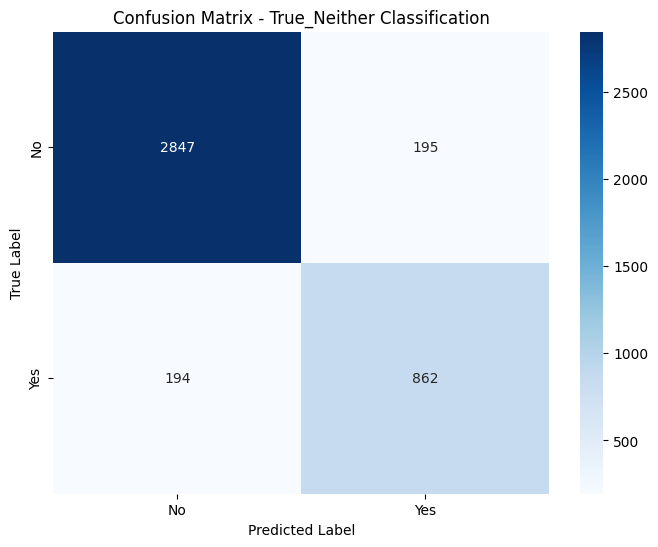


予測結果の例:
----------------------------------------------------------------------------------------------------
例 1:
正解: No (Not True_Neither)
予測: No (Not True_Neither)
実際のカテゴリ: True_Correct
----------------------------------------------------------------------------------------------------
例 2:
正解: No (Not True_Neither)
予測: No (Not True_Neither)
実際のカテゴリ: True_Correct
----------------------------------------------------------------------------------------------------
例 3:
正解: No (Not True_Neither)
予測: No (Not True_Neither)
実際のカテゴリ: True_Correct
----------------------------------------------------------------------------------------------------
例 4:
正解: No (Not True_Neither)
予測: No (Not True_Neither)
実際のカテゴリ: True_Correct
----------------------------------------------------------------------------------------------------
例 5:
正解: No (Not True_Neither)
予測: No (Not True_Neither)
実際のカテゴリ: True_Correct
-------------------------------------------------------------------------------------------

In [24]:
# Validationデータでの最終評価
print("=" * 50)
print("Validation データでの最終評価")
print("=" * 50)

# モデルを評価モードに設定
model.eval()

# Validationデータでの推論
predictions = []
true_labels = []

with torch.no_grad():
    for i, row in val_df.iterrows():
        # プロンプトをトークン化
        inputs = tokenizer(
            row["prompt"],
            return_tensors="pt",
            max_length=CFG.max_len,
            truncation=True,
            padding=True
        ).to(model.device)

        # 推論実行
        outputs = model.generate(
            **inputs,
            max_new_tokens=5,  # Yes/Noなので短く
            do_sample=False,
            temperature=1.0,
            pad_token_id=tokenizer.eos_token_id
        )

        # 生成された部分のみを取得
        generated_tokens = outputs[0][inputs["input_ids"].shape[1]:]
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()

        # Yes/Noに変換
        if "Yes" in generated_text:
            pred = 1
        elif "No" in generated_text:
            pred = 0
        else:
            # 曖昧な場合はlogitで判断
            logits = model(**inputs).logits[0, -1, :]
            yes_logit = logits[yes_token_id].item()
            no_logit = logits[no_token_id].item()
            pred = 1 if yes_logit > no_logit else 0

        predictions.append(pred)
        true_labels.append(1 if row["completion"] == "Yes" else 0)

# メトリクス計算
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print()

# 詳細なレポート
print("分類レポート:")
print(classification_report(true_labels, predictions, target_names=["No (Not True_Neither)", "Yes (True_Neither)"]))

# 混同行列
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No", "Yes"],
            yticklabels=["No", "Yes"])
plt.title('Confusion Matrix - True_Neither Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 予測結果の例を表示
print("\n予測結果の例:")
print("-" * 100)
for i in range(min(5, len(val_df))):
    print(f"例 {i+1}:")
    print(f"正解: {'Yes (True_Neither)' if true_labels[i] == 1 else 'No (Not True_Neither)'}")
    print(f"予測: {'Yes (True_Neither)' if predictions[i] == 1 else 'No (Not True_Neither)'}")
    print(f"実際のカテゴリ: {val_df.iloc[i]['Category']}")
    print("-" * 100)